In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
#Importing data
df = pd.read_csv('Train.csv')
#Printing head
df.head()


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


### As seen from the print statements above, we are given 2 years of data(2012-2014) at hourly level with the number of commuters travelling and we need to estimate the number of commuters for future.


* Subsetting the dataset from (August 2012 – Dec 2013)
* Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.
* Aggregating the dataset at daily basis

In [2]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('Train.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/linu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


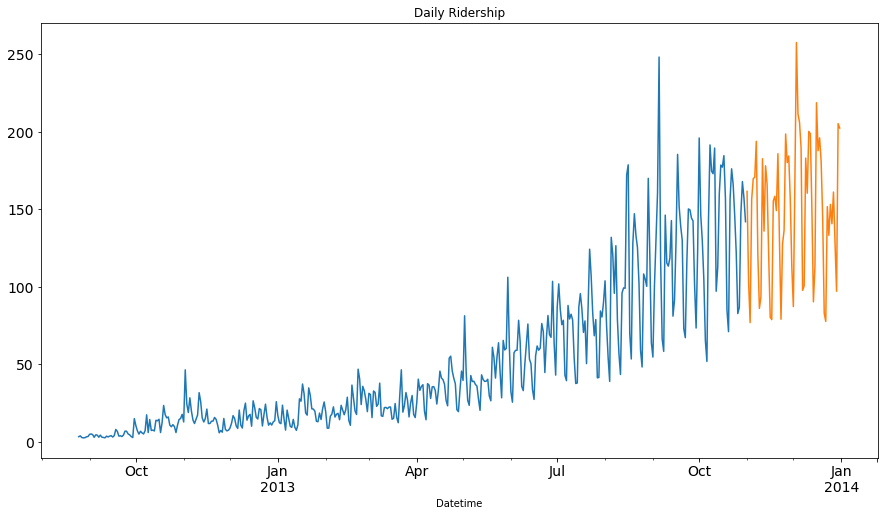

In [3]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

# Method 1: Start with a Naive Approach

### Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

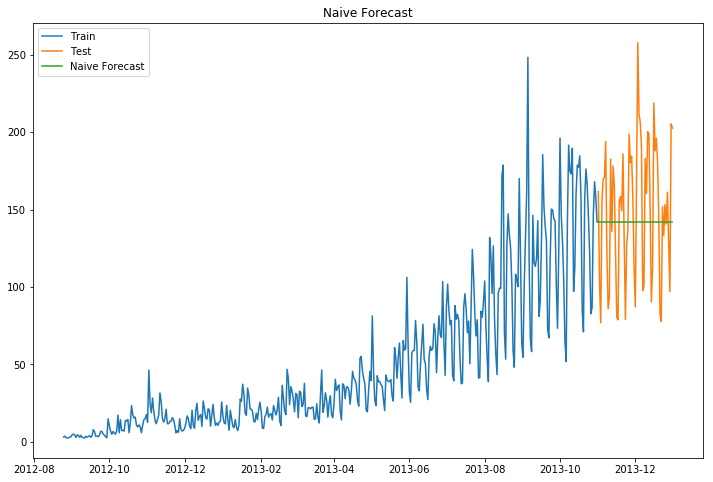

In [4]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

## We will now calculate RMSE to check to accuracy of our model on test data set.

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

43.91640614391676


#### We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. Now we will look at another technique and try to improve our score.

# Method 2: – Simple Average

#### Forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

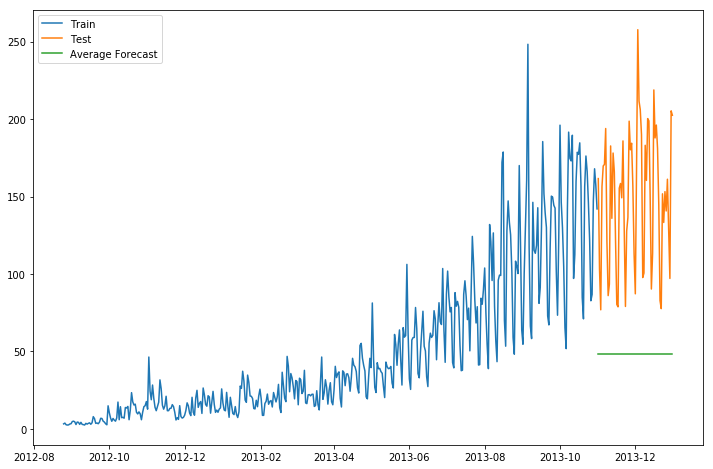

In [6]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [7]:
### We will now calculate RMSE to check to accuracy of our model.

In [8]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)


109.88526527082863


We can see that this model didn’t improve our score. Hence we can infer from the score that this method works best when the average at each time period remains constant. Though the score of Naive method is better than Average method, but this does not mean that the Naive method is better than Average method on all datasets. We should move step by step to each model and confirm whether it improves our model or not.

# Method 3 – Moving Average

As an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

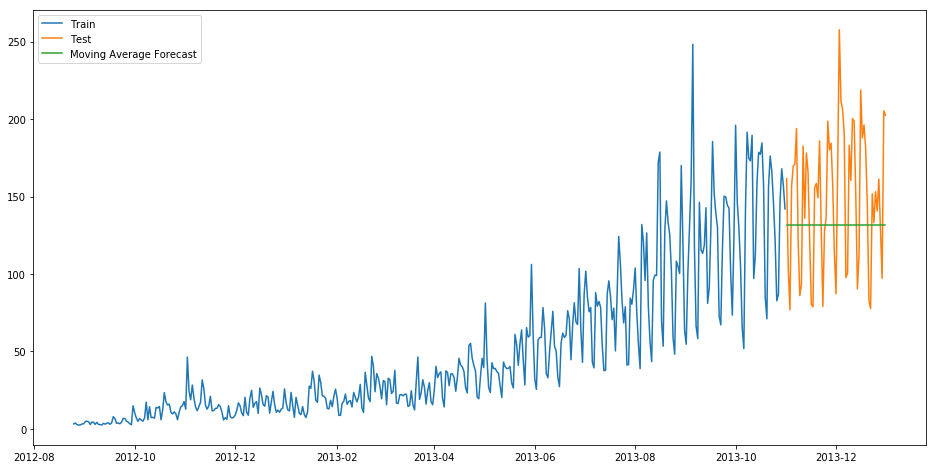

In [9]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [10]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

46.72840725106963


We can see that Naive method outperforms both Average method and Moving Average method for this dataset. Now we will look at Simple Exponential Smoothing method and see how it performs.

An advancement over Moving average method is Weighted moving average method. In the Moving average method as seen above, we equally weigh the past ‘n’ observations. But we might encounter situations where each of the observation from the past ‘n’ impacts the forecast in a different way. Such a technique which weighs the past observations differently is called Weighted Moving Average technique.

A weighted moving average is a moving average where within the sliding window values are given different weights, typically so that more recent points matter more. Instead of selecting a window size, it requires a list of weights (which should add up to 1). For example if we pick [0.40, 0.25, 0.20, 0.15] as weights, we would be giving 40%, 25%, 20% and 15% to the last 4 points respectively.

# Method 4 – Simple Exponential Smoothing

After we have understood the above methods, we can note that both Simple average and Weighted moving average lie on completely opposite ends. We would need something between these two extremes approaches which takes into account all the data while weighing the data points differently. For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

where 0≤ α ≤1 is the smoothing parameter.

The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

If you stare at it just long enough, you will see that the expected value ŷx is the sum of two products: α⋅yt and (1−α)⋅ŷ t-1.



So essentially we’ve got a weighted moving average with two weights: α and 1−α.

As we can see, 1−α is multiplied by the previous expected value ŷ x−1 which makes the expression recursive. And this is why this method is called Exponential. The forecast at time t+1 is equal to a weighted average between the most recent observation yt and the most recent forecast ŷ t|t−1.

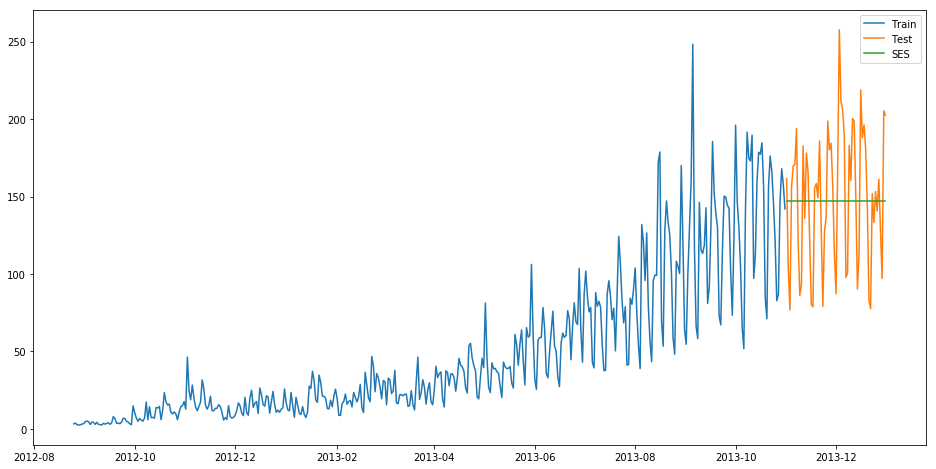

In [11]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [12]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

43.357625225228155


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.

# Method 5 – Holt’s Linear Trend method

If we use any of the above methods, it won’t take into account this trend. Trend is the general pattern of prices that we observe over a period of time. In this case we can see that there is an increasing trend.

Although each one of these methods can be applied to the trend as well.  E.g. the Naive method would assume that trend between last two points is going to stay the same, or we could average all slopes between all points to get an average trend, use a moving trend average or apply exponential smoothing.

But we need a method that can map the trend accurately without any assumptions. Such a method that takes into account the trend of the dataset is called Holt’s Linear Trend method.

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.

In [40]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(train.Count)
result = sm.tsa.stattools.adfuller(train.Count)

In [41]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

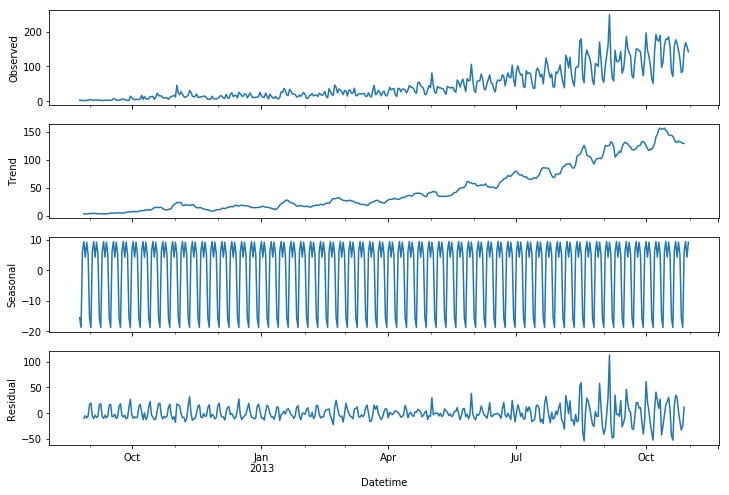

In [51]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))

plotseasonal(res, axes)
# plotseasonal(res, axes[:,1])
# plotseasonal(res, axes[:,2])

#plt.tight_layout()
plt.show()

We can see from the graphs obtained that this dataset follows an increasing trend. Hence we can use Holt’s linear trend to forecast the future prices.

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected forecast ŷ



The values we predicted in the above algorithms are called Level. In the above three equations, you can notice that we have added level and trend to generate the forecast equation.

As with simple exponential smoothing, the level equation here shows that it is a weighted average of observation and the within-sample one-step-ahead forecast The trend equation shows that it is a weighted average of the estimated trend at time t based on ℓ(t)−ℓ(t−1) and b(t−1), the previous estimate of the trend.

We will add these equations to generate Forecast equation. We can also generate a multiplicative forecast equation by multiplying trend and level instead of adding it. When the trend increases or decreases linearly, additive equation is used whereas when the trend increases of decreases exponentially, multiplicative equation is used.Practice shows that multiplicative is a more stable predictor, the additive method however is simpler to understand.



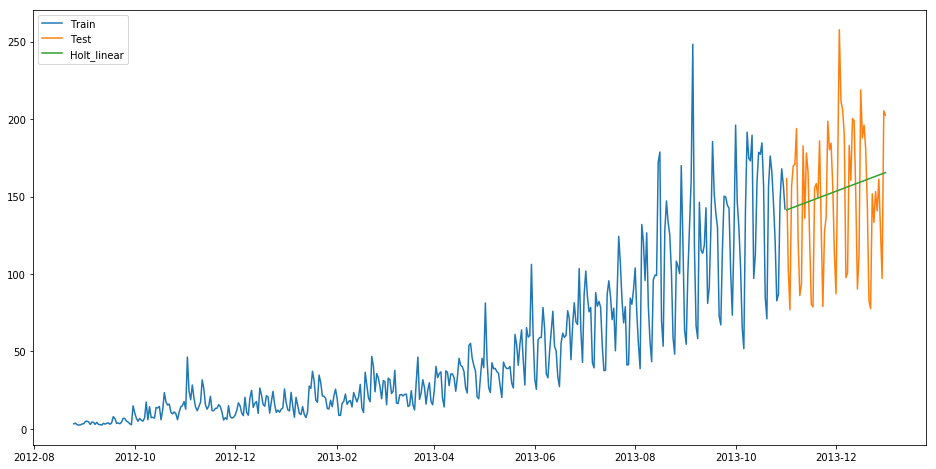

In [52]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [54]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

43.056259611507286


# Method 6 – Holt-Winters Method